# Tensorflow2.x for ["Gated Graph Sequence Neural Networks"](https://arxiv.org/pdf/1511.05493.pdf)



In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import sys
import os
import pickle as pkl
import scipy.sparse as sp


gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_visible_devices(devices=gpus[1:2], device_type='GPU')

## Load Data

In [2]:
dataset_name = "cora"

def preprocess_features(features):
    row_sum = np.array(features.sum(1))
    reverse_row_sum = np.power(row_sum,-1).flatten()
    reverse_row_sum[np.isinf(reverse_row_sum)] = 0.
    new_features = sp.diags(reverse_row_sum).dot(features)
    return new_features

def load_data(datasetname):
    names = ['x','tx','allx','y','ty','ally','graph']
    objects = {}
    for name in names:
        with open("data/ind.{}.{}".format(datasetname, name),'rb') as f:
            objects[name] = pkl.load(f, encoding='latin1')
    
    with open("data/ind.{}.test.index".format(datasetname), 'r') as f:
        test_index = []
        for line in f.readlines():
            test_index.append(int(line.strip()))

    test_index_reorder = np.sort(test_index)
    
    whole_features = sp.vstack((objects['allx'], objects['tx'])).tolil()

    whole_features[test_index] = whole_features[test_index_reorder]

    num_nodes = whole_features.shape[0]

    adj = nx.adjacency_matrix(nx.from_dict_of_lists(objects['graph']))

    whole_labels = np.r_[objects['ally'], objects['ty']]

    whole_labels[test_index] = whole_labels[test_index_reorder]

    train_idx = np.arange(len(objects['y']))
    val_idx = np.arange(len(objects['y']), len(objects['y'])+ 500)
    test_idx = test_index_reorder



    return adj, whole_features, whole_labels, train_idx, val_idx, test_idx


In [3]:
adj, whole_features, whole_labels, train_idx, val_idx, test_idx = load_data(dataset_name)
wholes_features = preprocess_features(whole_features).todense()

## Build Graph

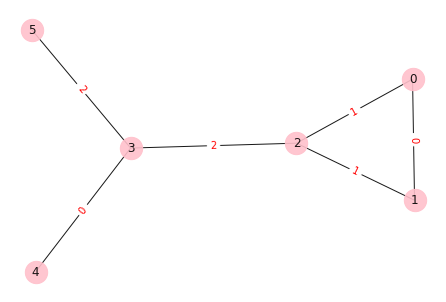

In [4]:
def build_graph(edges, edgetypes):    
    g = nx.Graph()

    for i, edge in enumerate(edges):
        g.add_edge(edge[0],edge[1],label = edgetypes[i])

    pos = nx.spring_layout(g)
    plt.figure()
    nx.draw(g,
            pos,
            edge_color='black',
            width=1,
            linewidths=1,
            node_size=500,
            node_color='pink',
            alpha=0.9,
            labels={node:node for node in g.nodes()})

    nx.draw_networkx_edge_labels(g,
                                 pos,
                                 edge_labels={(edges[0][0],edges[0][1]):edgetypes[0],
                                              (edges[1][0],edges[1][1]):edgetypes[1],
                                              (edges[2][0],edges[2][1]):edgetypes[2],
                                              (edges[3][0],edges[3][1]):edgetypes[3],
                                              (edges[4][0],edges[4][1]):edgetypes[4],
                                              (edges[5][0],edges[5][1]):edgetypes[5]},font_color='red')
    plt.axis('off')
    plt.show()
    return g



edges = np.array([[0,1,2,3,2,5], [1,2,3,4,0,3]]).T
sorted_edges = np.sort(edges)
features = np.ones(shape = (6, 10))
edgetypes = np.array([0,1,2,0,1,2])
g = build_graph(edges, edgetypes)
feature_dims = features.shape[1]
output_dims = 10

In [5]:
A = nx.adjacency_matrix(g) # without self loop


## Model

$h_{i}^{0} = [ x_i \| \mathbf{0} ]$

$a_{i}^{t} = \sum_{j\in\mathcal{N}(i)} W_{e_{ij}} h_{j}^{t}$

$h_{i}^{t+1} = \mathrm{GRU}(a_{i}^{t}, h_{i}^{t})$

In [6]:
# num_nodes = features.shape[0]
# feature_dim = features.shape[1]
# epochs = 500
# n_classes = whole_labels.shape[1]
# learning_rate = 5e-3
# L2_reg = 5e-4

class GatedGNN(keras.layers.Layer):
    def __init__(self, 
                 output_dims, 
                 g, 
                 class_num = None,
                 activation = keras.activations.softmax,
                 sparse = True,
                 n_steps=2, 
                 n_edgeTypes = 3, 
                 bias = True, 
                 **kwargs):
        """
        feature_dims: input features size,
        output_dims: output node_size,
        direct: bool,
        n_steps: num of steps of GRU (T in paper),
        n_edgetypes: num of edgeTypes,
        bias: default true.

         The number of input channels of :math:`\mathbf{x}_i` needs to be less or
    equal than :obj:`out_channels`.
        """
        super(GatedGNN, self).__init__(**kwargs)
        self.output_dims = output_dims
        self.n_steps = n_steps
        self.n_edgeTypes = n_edgeTypes
        self.bias = bias
        self.sparse = sparse
        self.gru = keras.layers.GRUCell(units = self.output_dims, use_bias=self.bias)
        self.g = g
        self.class_num = class_num
        # 为解决over fitting 先做个特征变换
        self.solve_overfitting = keras.layers.Dense(self.output_dims)

        # 每种类型的边赋予不同的weight 每个节点聚合outgoing neigh和incoming neigh
        self.edge_weights =[
            keras.layers.Dense(units = self.output_dims, 
                               kernel_initializer = keras.initializers.GlorotUniform, 
                               bias_initializer = keras.initializers.zeros,
                               use_bias=self.bias) 
            for _ in range(self.n_edgeTypes)
        ]
        if self.class_num is not None:
            self.output_layer = keras.layers.Dense(self.class_num)
        self.activation = activation
        self.num_nodes = self.g.number_of_nodes()
        self.adj_matrix = nx.adjacency_matrix(self.g)
        if self.n_edgeTypes > 1:
            self._process_graph()
        
    
    def _process_graph(self):
        """ 
        label: edges
        {   0: [(0, 1), (1, 0), (3, 4), (4, 3)],
            1: [(0, 2), (1, 2), (2, 1), (2, 0)],
            2: [(2, 3), (3, 2), (3, 5), (5, 3)] }
        """
        self.adj = self.g.adj
        self.label_edge_dict = {}
        for item in self.adj.items():
            head = item[0]
            tails = item[1]
            for node in tails.items():
                tail = node[0]
                label = node[1]['label']
                if label not in self.label_edge_dict:
                    self.label_edge_dict[label] = []
                self.label_edge_dict[label].append((head, tail))
    
    def _get_edgedict(self, label):
        edge_dict = {}
        if self.n_edgeTypes > 1:
            edges = self.label_edge_dict[label]
            for edge in edges:
                head = edge[0]
                tail = edge[1]
                if head not in edge_dict:
                    edge_dict[head] = set()
                if tail not in edge_dict:
                    edge_dict[tail] = set()
                edge_dict[head].add(tail)
                edge_dict[tail].add(head)
        else:
            edges = list(self.g.edges)
            for edge in edges:
                head = edge[0]
                tail = edge[1]
                if head not in edge_dict:
                    edge_dict[head] = set()
                if tail not in edge_dict:
                    edge_dict[tail] = set()
                edge_dict[head].add(tail)
                edge_dict[tail].add(head)
        return edge_dict

    def _message_passing(self, features, adj_mask):
        adj_mask = self._csr_to_SparseTensor(adj_mask)
        agg = tf.sparse.sparse_dense_matmul(tf.cast(adj_mask,tf.float32), features) # neigh aggregation
        return agg

    def _dense_to_csr(self, edges):
        num_data = edges.shape[1]
        edges = edges.T
        row = edges[0]
        col = edges[1]
        data  = np.arange(edges.shape[1])
        return sp.csr_matrix((data,(row,col)),shape = (self.num_nodes, self.num_nodes))

    def _csr_to_SparseTensor(self, csr_matrix):
        if sp.isspmatrix_csr(csr_matrix):
            csr_matrix = csr_matrix.tocoo()
        row = csr_matrix.row
        col = csr_matrix.col
        pos = np.c_[row,col]
        data = csr_matrix.data
        shape = csr_matrix.shape
        return tf.SparseTensor(pos, data, shape)


    def _mask_adj(self, edge_type):
        # edge_type = 0,1,2
        if self.n_edgeTypes > 1:
            edges = self.label_edge_dict[edge_type]
            edges = np.array(list(map(lambda x: list(x), edges)))
            if not self.sparse:
                mask_adj = np.zeros(shape=(self.num_nodes,self.num_nodes),dtype = np.int)
                mask_adj[edges[:,0], edges[:,1]] = 1
                return mask_adj
            else:
                mask_adj = self._dense_to_csr(edges)
                return mask_adj
        else:
            edges = self.g.edges
            edges = np.array(list(map(lambda x: list(x), edges)))
            if not self.sparse:
                mask_adj = np.zeros(shape=(self.num_nodes,self.num_nodes),dtype = np.int)
                mask_adj[edges[:,0], edges[:,1]] = 1
                return mask_adj
            else:
                mask_adj = self._dense_to_csr(edges)
                return mask_adj


    def build(self, input_shape):
        self.built = True


    def call(self,inputs):
        features = inputs
        if self.output_dims > features.shape[1]:
            # zero_pad = tf.zeros(shape = (features.shape[0], int(self.output_dims - features.shape[1])))
            # features = tf.concat([features, zero_pad], axis = 1)
            zero_pad = int(self.output_dims - features.shape[1])
            padding = [[0,0],[0,zero_pad]]
            features = tf.pad(features,padding,"CONSTANT")
        features = self.solve_overfitting(features)
        for _ in range(self.n_steps):
            agg_whole = []
            for i in range(self.n_edgeTypes):
                # edges = self.label_edge_dict[i]
                # edge_dict = self._get_edgedict(i)
                # head = list(edge_dict.keys())
                # neighbor_of_head = np.array(list(
                #     map(lambda x: list(x), list(edge_dict.values()))))

                # message passing
                Wh_j = self.edge_weights[i](features)  # feature transform
                # 只包含edgeType[i]的邻接矩阵
                edgeType_adj_mask = self._mask_adj(i)
                # 为每个节点聚合edge type = i的邻居特征
                agg = self._message_passing(Wh_j, edgeType_adj_mask) # NxD
                agg_whole.append(agg)
            a = tf.reduce_sum(tf.stack(agg_whole, axis=0), axis=0)
            features = self.gru(a, features)[0]
        if self.class_num is not None:
            out = self.output_layer(features)
            features = self.activation(out)
        return features


In [7]:
inputs = keras.Input(shape=(feature_dims,))

gategnn = GatedGNN(output_dims=11,
                   g = g,
                   n_steps=2,
                   n_edgeTypes=3,
                   bias=False)(inputs)

model = keras.models.Model(inputs = inputs, outputs = gategnn)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
gated_gnn (GatedGNN)         (6, 11)                   1221      
Total params: 1,221
Trainable params: 1,221
Non-trainable params: 0
_________________________________________________________________


In [8]:
model(features)

<tf.Tensor: shape=(6, 11), dtype=float32, numpy=
array([[-0.19561294, -0.18606089, -0.3058448 , -0.00210386, -0.22446665,
         0.06467547,  0.21159919, -0.5133848 , -0.24325022, -0.05635349,
         0.24905029],
       [-0.8035495 , -0.5949438 , -0.9550313 , -0.04554544, -0.29970688,
        -0.38233182,  0.0114895 ,  0.02880734, -0.850068  ,  0.45329002,
         0.6557997 ],
       [-0.9402922 , -0.22307855,  0.6025761 , -0.46428153, -0.7155764 ,
        -0.9656445 , -0.6957068 ,  0.8176597 , -0.8994152 ,  0.77796894,
         0.7788987 ],
       [-0.8356583 , -1.0829695 , -1.1067482 ,  0.00159816, -0.41905516,
         0.26678243,  0.62082684, -0.80135363, -0.70830625,  0.18730104,
        -0.02687861],
       [-0.9959234 , -0.57641053, -1.3924615 ,  0.06712859, -0.6346684 ,
        -0.55409473,  0.9210373 , -0.6864879 , -0.8501884 ,  0.95742124,
         0.510429  ],
       [-0.41796333, -1.3016931 , -0.32993513, -0.02813825, -0.40931883,
         0.729366  ,  0.9909551 , -0.7

# Train on Cora for Node Classification

In [9]:
G_cora = nx.from_scipy_sparse_matrix(adj)  # return nx Graph

In [10]:
cora_dims = whole_features.shape[1]

In [11]:
num_nodes = whole_features.shape[0]
feature_dim = whole_features.shape[1]
epochs = 500
n_classes = whole_labels.shape[1]
learning_rate = 5e-3
L2_reg = 5e-4

embed_dims = 16
inputs = keras.Input(shape=(cora_dims,))

gated_cora = GatedGNN(output_dims=embed_dims,
                   g = G_cora,
                   class_num = n_classes,
                   n_steps=1,
                   n_edgeTypes=1,
                   bias=False)(inputs)

model_cora = keras.models.Model(inputs = inputs, outputs = gated_cora )
model_cora.summary()

model_cora.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(learning_rate),
weighted_metrics=['categorical_crossentropy', 'acc'])

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1433)]            0         
_________________________________________________________________
gated_gnn_1 (GatedGNN)       (2708, 7)                 24855     
Total params: 24,855
Trainable params: 24,855
Non-trainable params: 0
_________________________________________________________________


## Generate Train Valid Test Data

In [12]:
def sample_mask(idx, l):
    mask = np.zeros(l)
    mask[idx] = 1
    return np.array(mask, dtype=np.bool)

y_train = np.zeros(whole_labels.shape)
train_mask = sample_mask(train_idx, whole_labels.shape[0])
y_train[train_mask] = whole_labels[train_mask]

y_val = np.zeros(whole_labels.shape)
val_mask = sample_mask(val_idx, whole_labels.shape[0])
y_val[val_mask] = whole_labels[val_mask]

y_test = np.zeros(whole_labels.shape)
test_mask = sample_mask(test_idx, whole_labels.shape[0])
y_test[test_mask] = whole_labels[test_mask]

In [14]:
# callback = [ keras.callbacks.EarlyStopping(monitor="val_acc",
#               min_delta=1e-4, patience=10)]

num_nodes = whole_labels.shape[0]
features_ = whole_features.todense()
history = model_cora.fit(x = features_, 
                         y = y_train, 
                         sample_weight= train_mask,
                         validation_data=(features_, y_val, val_mask),batch_size = num_nodes, epochs = 300, shuffle = False, workers=10, use_multiprocessing=True)

ategorical_crossentropy: 1.8873 - val_acc: 0.5000
Epoch 206/300
1/1 [==============================] - 0s 64ms/step - loss: 3.9001e-04 - categorical_crossentropy: 0.0075 - acc: 1.0000 - val_loss: 0.3487 - val_categorical_crossentropy: 1.8884 - val_acc: 0.5000
Epoch 207/300
1/1 [==============================] - 0s 61ms/step - loss: 3.8783e-04 - categorical_crossentropy: 0.0075 - acc: 1.0000 - val_loss: 0.3488 - val_categorical_crossentropy: 1.8894 - val_acc: 0.5000
Epoch 208/300
1/1 [==============================] - 0s 62ms/step - loss: 3.8566e-04 - categorical_crossentropy: 0.0075 - acc: 1.0000 - val_loss: 0.3490 - val_categorical_crossentropy: 1.8902 - val_acc: 0.4980
Epoch 209/300
1/1 [==============================] - 0s 67ms/step - loss: 3.8351e-04 - categorical_crossentropy: 0.0074 - acc: 1.0000 - val_loss: 0.3491 - val_categorical_crossentropy: 1.8910 - val_acc: 0.4980
Epoch 210/300
1/1 [==============================] - 0s 62ms/step - loss: 3.8138e-04 - categorical_crossentrop

## Test

In [15]:
eval_results = model_cora.evaluate(features_, y_test, sample_weight=test_mask, batch_size=num_nodes)

1/1 [==============================] - 0s 4ms/step - loss: 0.7394 - categorical_crossentropy: 2.0023 - acc: 0.3590
